In [1]:
import json
import re
from datetime import datetime, timedelta

import altair as alt
import pandas as pd
import teammachine as tm

alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
# Construct a teammachine Client with credentials downloaded from https://app.teammachine.io/spaces/api-clients
with open('/path/to/credentials.json') as f:
    credentials = json.load(f)
    
client = tm.Client(**credentials)

In [3]:
# Fetch a list of our code repositories
repos_query = client.code_repo
repos = repos_query.request()

# Results are nested dictionaries and lists like 
# {'CodeRepo': [{'tm_id': 'a', 'tm_display_name': 'b', 'node_type': 'CodeRepo'} ...]}}
print(repos['CodeRepo'][0])

{'tm_id': 'ghr-4OwhLW3bR6z40O', 'tm_display_name': 'keylines-eval', 'node_type': 'CodeRepo'}


In [4]:
# If you have Pandas installed, it's usually more convenient to use Pandas DataFrames
# This result set has only one DataFrame, a list of code_repos
print(repos.dataframes)

repos.dataframes.code_repo.head()

<DataFrames: code_repo>


,tm_id,tm_display_name,node_type
0,ghr-4OwhLW3bR6z40O,keylines-eval,CodeRepo
1,ghr-3QWO9uRp57DB75,js-sdk,CodeRepo
2,ghr-3EeDhmgImKv3o,tm-superset,CodeRepo
3,ghr-4rj9Xts3AxQ5ye,keylines-react-eval,CodeRepo
4,ghr-5aqX1Mb9IvhN37,caddy,CodeRepo


In [5]:
# Let's extend our earlier query to get the activity in each repo
# NOTE: .activity(...) creates a new Query object and does not modify 
# the "repos_query"
commits = repos_query.activity(start_date='2019-01-01').request()

In [6]:
# This result set now has two dataframes: a list of repos and the related activity
print(commits.dataframes)
commits.dataframes.code_repo.head()

<DataFrames: code_repo_activity, code_repo>


,tm_id,tm_display_name,node_type
0,ghr-4OwhLW3bR6z40O,keylines-eval,CodeRepo
1,ghr-3QWO9uRp57DB75,js-sdk,CodeRepo
2,ghr-3EeDhmgImKv3o,tm-superset,CodeRepo
3,ghr-4rj9Xts3AxQ5ye,keylines-react-eval,CodeRepo
4,ghr-5aqX1Mb9IvhN37,caddy,CodeRepo


In [7]:
# NOTE: the dataframe names follow the names found inside the API results and nested objects
# like "created_by" are flattened
commits.dataframes.code_repo_activity.sort_values('created_at').head()

,code_repo_id,tm_id,tm_display_name,node_type,created_at,created_by_tm_id,created_by_tm_display_name,created_by_is_human
1243,ghr-2n9jkF4O9ckfrX,gic-38ziVLvYWEosOk,add dropbox for biz\n,CodeCommit,2019-01-01T13:42:38Z,iid-6lg5CKjkTiiUr,Uros Rapajic,True
1242,ghr-2n9jkF4O9ckfrX,gic-5K2VjFtdCX3Ssj,Merge branch 'master' of github.com:team-machi...,CodeCommit,2019-01-01T13:42:48Z,iid-6lg5CKjkTiiUr,Uros Rapajic,True
1241,ghr-2n9jkF4O9ckfrX,gic-5RymHcc1H5dJ8f,update version\n,CodeCommit,2019-01-01T13:52:48Z,iid-6lg5CKjkTiiUr,Uros Rapajic,True
1240,ghr-2n9jkF4O9ckfrX,gic-1MZEIDKmGCnwEM,rename job\n,CodeCommit,2019-01-01T15:34:07Z,iid-6lg5CKjkTiiUr,Uros Rapajic,True
1239,ghr-2n9jkF4O9ckfrX,gic-5YkPe0JVPq7Rwa,still need slack sec\n,CodeCommit,2019-01-01T15:55:28Z,iid-6lg5CKjkTiiUr,Uros Rapajic,True


In [8]:
# Child dataframes have references to parent objects so you can join the tables together
commits_df = commits.dataframes.code_repo_activity.merge(
    # rename the columns on the repos DataFrame to avoid naming conflicts
    commits.dataframes.code_repo.rename(columns={
        'tm_id': 'code_repo_id',
        'tm_display_name': 'code_repo_name',
        'node_type': 'code_repo_node_type',
    }), 
).sort_index(axis=1)

commits_df.sort_values('created_at').head()

,code_repo_id,code_repo_name,code_repo_node_type,created_at,created_by_is_human,created_by_tm_display_name,created_by_tm_id,node_type,tm_display_name,tm_id
2600,ghr-2n9jkF4O9ckfrX,tm-gitops,CodeRepo,2019-01-01T13:42:38Z,True,Uros Rapajic,iid-6lg5CKjkTiiUr,CodeCommit,add dropbox for biz\n,gic-38ziVLvYWEosOk
2599,ghr-2n9jkF4O9ckfrX,tm-gitops,CodeRepo,2019-01-01T13:42:48Z,True,Uros Rapajic,iid-6lg5CKjkTiiUr,CodeCommit,Merge branch 'master' of github.com:team-machi...,gic-5K2VjFtdCX3Ssj
2598,ghr-2n9jkF4O9ckfrX,tm-gitops,CodeRepo,2019-01-01T13:52:48Z,True,Uros Rapajic,iid-6lg5CKjkTiiUr,CodeCommit,update version\n,gic-5RymHcc1H5dJ8f
2597,ghr-2n9jkF4O9ckfrX,tm-gitops,CodeRepo,2019-01-01T15:34:07Z,True,Uros Rapajic,iid-6lg5CKjkTiiUr,CodeCommit,rename job\n,gic-1MZEIDKmGCnwEM
2596,ghr-2n9jkF4O9ckfrX,tm-gitops,CodeRepo,2019-01-01T15:55:28Z,True,Uros Rapajic,iid-6lg5CKjkTiiUr,CodeCommit,still need slack sec\n,gic-5YkPe0JVPq7Rwa


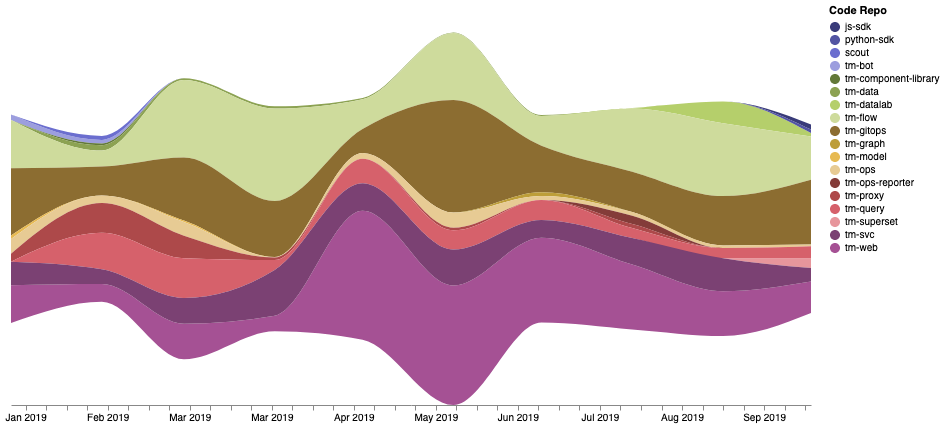

In [9]:
# Let's plot monthly activity across the code repos using altair (https://altair-viz.github.io/)

alt.Chart(
    commits_df,
    height=400,
    width=800,
).mark_area(interpolate='monotone').encode(
    x=alt.X('yearmonth(created_at):T', axis=alt.Axis(title=None)),
    y=alt.Y('count():Q', stack='center', axis=None),
    color=alt.Color(
        'code_repo_name:N',
        scale=alt.Scale(scheme='category20b'),
        legend=alt.Legend(title='Code Repo'),
    ),
    tooltip=[
        alt.Tooltip('code_repo_name', title='Code Repo'),
        alt.Tooltip('yearmonth(created_at)', title='Month'),
        alt.Tooltip('count()', title='Commits'),
    ]
).configure_axis(grid=False).configure_view(strokeWidth=0)